# Test the customize GP models with hyperbolic tangent mean

## Imports

In [1]:
import logging

from dotenv import load_dotenv

import matplotlib.pyplot as plt

import numpy as np

from scipy import stats

import seaborn as sns


# Force autoreload
%load_ext autoreload
%autoreload 2

# Logger
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)s: %(message)s',
    level=logging.INFO,
    datefmt='%I:%M:%S'
)

# Load dotenv
_ = load_dotenv()

In [2]:
from gp_sand.generate import NoisyPCGenerator
from gp_sand.means import HyperbolicTangentMean
from gp_sand.models import BaseExactGP, BaseSparseGP

## Setup

In [3]:
generator = NoisyPCGenerator(cov=.05)

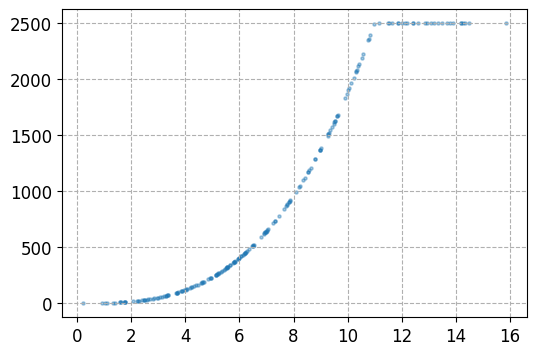

In [4]:
ws = generator.sample_x()
pw = generator.true_signal(ws)

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.scatter(ws, pw, s=5, alpha=.4)

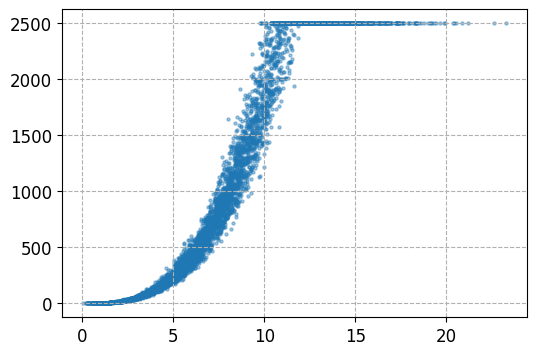

In [5]:
ws, pw = generator.training_data(n_samples=5000, to_torch=False)

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.scatter(ws, pw, s=5, alpha=.4)


## Homeskedastic model

In [6]:
train_x, train_y = generator.training_data(n_samples=10000)
train_y /= generator.power_rated

model = BaseSparseGP(
    train_x,
    train_y,
    mean_module=HyperbolicTangentMean(),
)

In [7]:
model.fit(train_x, train_y);

03:41:38 INFO: Iter 1 of 250: Noise:  0.744 - Loss:  1.608
03:41:40 INFO: Iter 25 of 250: Noise:  0.888 - Loss:  1.029
03:41:42 INFO: Iter 50 of 250: Noise:  0.337 - Loss:  0.487
03:41:44 INFO: Iter 75 of 250: Noise:  0.066 - Loss: -0.234
03:41:46 INFO: Iter 100 of 250: Noise:  0.014 - Loss: -0.929
03:41:48 INFO: Iter 125 of 250: Noise:  0.005 - Loss: -1.347
03:41:50 INFO: Iter 150 of 250: Noise:  0.004 - Loss: -1.451
03:41:52 INFO: Iter 175 of 250: Noise:  0.002 - Loss: -1.552
03:41:54 INFO: Iter 200 of 250: Noise:  0.002 - Loss: -1.573
03:41:56 INFO: Iter 225 of 250: Noise:  0.002 - Loss: -1.578
03:41:58 INFO: Iter 250 of 250: Noise:  0.002 - Loss: -1.564
03:41:58 INFO: Prediction scores:
+--------+-------+-----------+--------+-------+--------+-------+
| target |  bias | bias_perc |  cov   |  mae  | nrmse  |  rmse |
+--------+-------+-----------+--------+-------+--------+-------+
|  pred  | 0.011 |   3.117   | 13.472 | 0.031 | 13.996 | 0.049 |
+--------+-------+-----------+--------+-

### Visu

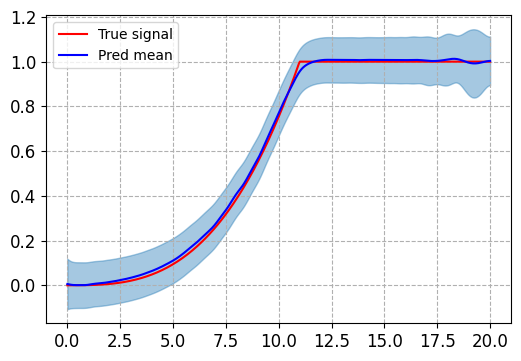

In [8]:
test_x = np.linspace(0, 20, 501)
test_y = generator.true_signal(test_x) / generator.power_rated

f_x, upper, lower = model.predict(test_x)

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.plot(test_x, test_y, c='r', label='True signal')
ax.plot(test_x, f_x.mean, c='blue', label='Pred mean')
ax.fill_between(
    test_x,
    lower,
    upper,
    color='tab:blue',
    alpha=.4,
)

ax.legend()

[None]

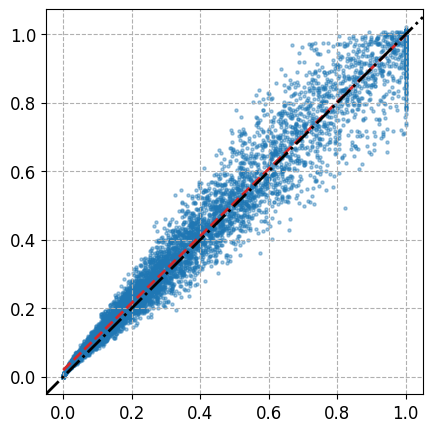

In [9]:
test_x, test_y = generator.training_data(n_samples=10000)
test_y /= generator.power_rated

f_x = model.predict(test_x, False)

_, ax = plt.subplots(figsize=(6, 5))
ax.grid(ls='--')

sns.regplot(
    x=test_y.numpy(),
    y=f_x.mean.numpy(),
    scatter_kws=dict(
        s=5,
        alpha=.4
    ),
    line_kws=dict(
        ls='--',
        lw=2,
        color='tab:red',
    )
),

ax.axline((0, 0), slope=1, ls='-.', lw=2, c='k')
ax.set(aspect='equal')

## Heteroskedastic models

In [10]:
from gpytorch.constraints import Positive
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.likelihoods.noise_models import HeteroskedasticNoise
from gpytorch.means import ConstantMean

import torch
from torch import nn


# PACKAGE IMPORTS
from gp_sand.likelihoods import HeteroskedasticGaussianLikelihood
from gp_sand.means import HyperbolicTangentMean
from gp_sand.models import BaseSparseGP


# Generate training data
train_x, train_y = generator.training_data(n_samples=1000)
train_y /= generator.power_rated


# Set up the GP for residuals
noise_constaint = Positive()
noise_likelihood = GaussianLikelihood()
# noise_likelihood.noise = 0.05
# noise_likelihood.requires_grad_(False)
train_noise = (
    noise_constaint
    .inverse_transform(
        torch.ones_like(train_y) * train_y.std()
    )
)
noise_gp = BaseExactGP(
    train_x,
    noise_constaint.inverse_transform(torch.ones_like(train_y) * train_y.std()),
    mean_module=ConstantMean(),
    covar_module=ScaleKernel(MaternKernel(nu=2.5)),
    likelihood=noise_likelihood,
)
noise_gp.mean_module.raw_constant = nn.Parameter(train_noise.mean())


# Define the heteroskedastic ll
noise_covar = HeteroskedasticNoise(
    noise_gp,
    noise_constraint=noise_constaint
)
likelihood = HeteroskedasticGaussianLikelihood(noise_covar)


model = BaseExactGP(
    train_x,
    train_y,
    mean_module=HyperbolicTangentMean(),
    # likelihood=GaussianLikelihood(),
    likelihood=likelihood
)

In [11]:
from gpytorch.mlls import VariationalELBO, ExactMarginalLogLikelihood

n_batchs = 50
n_epochs = 10

# Set training mode
model.train()
model.mean_module.train()
likelihood.train()
noise_gp.train()
noise_gp.likelihood.eval()


# Losses model
noise_mll = ExactMarginalLogLikelihood(
    noise_gp.likelihood,
    noise_gp,
    # num_data=train_y.size(0)
)
mll = ExactMarginalLogLikelihood(
    model.likelihood,
    model,
    # num_data=train_y.size(0)
)


# Optimizer
noise_optim = torch.optim.Adam(noise_gp.parameters(), lr=.1)
optim = torch.optim.Adam(model.parameters(), lr=.1)


# Start
noise_loss = np.array([0])
for nb in range(n_batchs):
    for n in range(n_epochs):
        # Zero grad
        optim.zero_grad()

        # Pred for main model
        pred = model(train_x)

        # Loss and backward
        loss = - mll(pred, train_y, train_x)
        loss.backward()
        optim.step()

    with torch.no_grad():
        res = (pred.mean - train_y).pow(2)
        res = noise_constaint.inverse_transform(res)
        noise_gp.set_train_data(train_x, res, strict=False)

    for n in range(n_epochs):
        # Zero grad
        noise_optim.zero_grad()

        # Pred for noise
        noise_pred = noise_gp(train_x)

        # Loss and backward
        noise_loss = - noise_mll(noise_pred, res)
        noise_loss.backward()
        noise_optim.step()

    
    msg = f'Batch {nb + 1} of {n_batchs}: ' \
          f'Loss (main): {loss.item():.3f},\t'  \
          f'Loss (latent): {noise_loss.item():.3f},\t'  # \
    logger.info(msg)

    # if (n + 1) % 25 == 0:


03:42:01 INFO: Batch 1 of 50: Loss (main): 0.406,	Loss (latent): 1.171,	
03:42:02 INFO: Batch 2 of 50: Loss (main): -0.154,	Loss (latent): 1.275,	
03:42:04 INFO: Batch 3 of 50: Loss (main): -0.242,	Loss (latent): 1.287,	
03:42:05 INFO: Batch 4 of 50: Loss (main): -0.391,	Loss (latent): 1.326,	
03:42:06 INFO: Batch 5 of 50: Loss (main): -0.664,	Loss (latent): 1.582,	
03:42:07 INFO: Batch 6 of 50: Loss (main): -1.251,	Loss (latent): 1.994,	
03:42:12 INFO: Batch 7 of 50: Loss (main): -1.888,	Loss (latent): 1.511,	
03:42:16 INFO: Batch 8 of 50: Loss (main): -1.434,	Loss (latent): 1.942,	
03:42:19 INFO: Batch 9 of 50: Loss (main): -1.887,	Loss (latent): 1.573,	
03:42:22 INFO: Batch 10 of 50: Loss (main): -1.669,	Loss (latent): 1.911,	
03:42:25 INFO: Batch 11 of 50: Loss (main): -1.960,	Loss (latent): 1.525,	
03:42:28 INFO: Batch 12 of 50: Loss (main): -1.794,	Loss (latent): 1.967,	
03:42:30 INFO: Batch 13 of 50: Loss (main): -1.912,	Loss (latent): 1.603,	
03:42:33 INFO: Batch 14 of 50: Loss

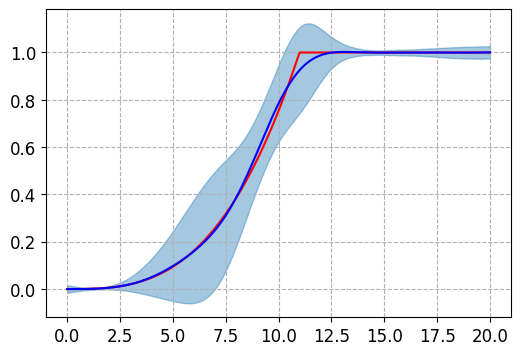

In [12]:
test_x = torch.linspace(0, 20, 201)
test_y = generator.true_signal(test_x) / generator.power_rated


model.eval()
with torch.no_grad():
    f_pred = model(test_x)
    y_pred = model.likelihood(f_pred, test_x)

    lower, upper = y_pred.confidence_region()

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.plot(test_x, test_y, c='r', label='True signal')
ax.plot(test_x, f_pred.mean, c='blue', label='Pred mean')
ax.fill_between(
    test_x,
    lower,
    upper,
    color='tab:blue',
    alpha=.4,
)

c:\Users\pcja001\git\pygp-sandbox\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


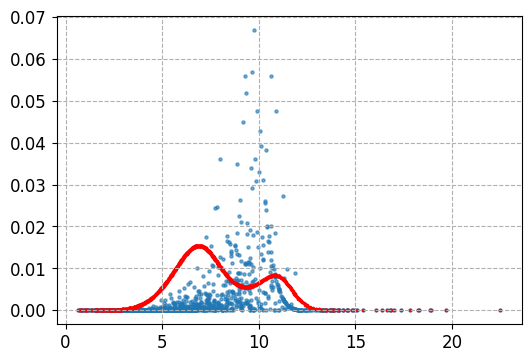

In [13]:
# test_x = torch.linspace(0, 20, 201)
# test_y = generator.true_signal(test_x) / generator.power_rated


model.eval()
with torch.no_grad():
    f_pred = model(train_x)
    # y_pred = model.likelihood(f_pred, test_x)

    res = (train_y - f_pred.mean)**2

    f_noise = noise_gp(train_x)

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.scatter(train_x, res, s=5, alpha=.6)
ax.scatter(train_x, noise_constaint.transform(f_noise.mean), s=2.5, c='r')

## Heteoskedastic model on zero-mean data

#### Get the training data

In [14]:
train_x, train_y = generator.training_data(n_samples=1000)
train_y /= generator.power_rated

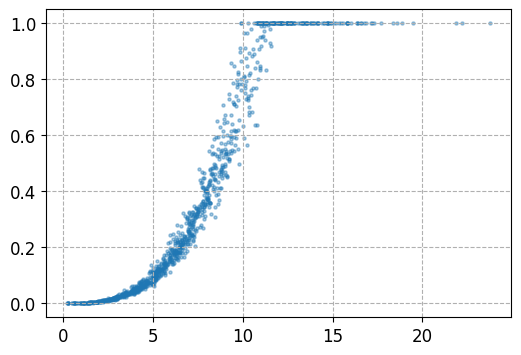

In [15]:
# ws, pw = generator.training_data(n_samples=5000, to_torch=False)

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.scatter(train_x, train_y, s=5, alpha=.4)


#### Train hyperbolic tangent model alone

In [16]:
import torch
from torch.nn import MSELoss
from torch.optim import Adam

from gp_sand.means import HyperbolicTangentMean



n_epochs = 50

mean_model = HyperbolicTangentMean()
mean_model.scale = torch.nn.Parameter(torch.tensor(1.0), requires_grad=False)
mean_model.train()

# Loss and optim
obj = MSELoss()
optimizer = Adam(mean_model.parameters(), lr=.1)

for n in range(n_epochs):
    optimizer.zero_grad()
    pred = mean_model(train_x)
    loss = obj(pred, train_y)
    loss.backward()
    optimizer.step()

    if n == 0 or (n + 1) % 5 == 0:
        msg = f'Training epoch {n + 1:2d} of {n_epochs}: ' \
              f'Loss= {loss.item()}'
        logger.info(msg)

03:44:21 INFO: Training epoch  1 of 50: Loss= 0.01001414842903614
03:44:21 INFO: Training epoch  5 of 50: Loss= 0.00432113092392683
03:44:21 INFO: Training epoch 10 of 50: Loss= 0.003557253396138549
03:44:21 INFO: Training epoch 15 of 50: Loss= 0.003924522083252668
03:44:21 INFO: Training epoch 20 of 50: Loss= 0.0034053560812026262
03:44:21 INFO: Training epoch 25 of 50: Loss= 0.003104445291683078
03:44:21 INFO: Training epoch 30 of 50: Loss= 0.003237999277189374
03:44:21 INFO: Training epoch 35 of 50: Loss= 0.0031954862643033266
03:44:21 INFO: Training epoch 40 of 50: Loss= 0.0031109019182622433
03:44:21 INFO: Training epoch 45 of 50: Loss= 0.003128171432763338
03:44:21 INFO: Training epoch 50 of 50: Loss= 0.0031062879133969545


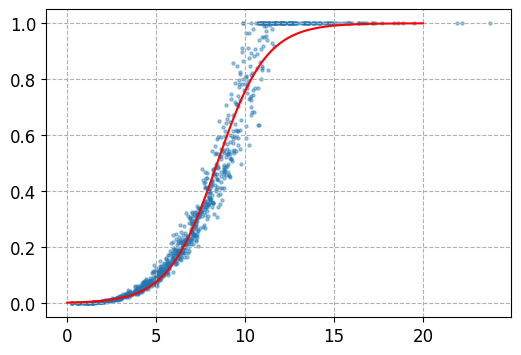

In [17]:
test_x = torch.linspace(0, 20, 401)

mean_model.eval()
with torch.no_grad():
    mean_pred = mean_model(test_x)


_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.scatter(train_x, train_y, s=5, alpha=.4)
ax.plot(test_x, mean_pred, lw=1.5, c='r')

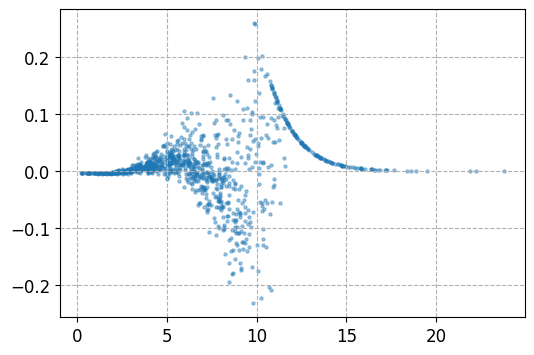

In [18]:
with torch.no_grad():
    train_y0 = train_y - mean_model(train_x)

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.scatter(train_x, train_y0, s=5, alpha=.4)

### Train model on zero mean data

## Test GPyTorch implementation of Sparse GP with Heteoskedastic Noise

### Get the training data

In [19]:
train_x, train_y = generator.training_data(n_samples=10000)
train_y /= generator.power_rated

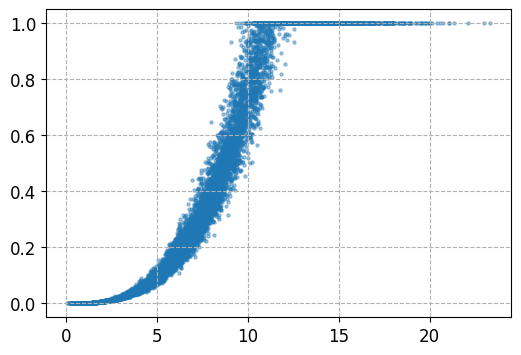

In [20]:
# ws, pw = generator.training_data(n_samples=5000, to_torch=False)

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.scatter(train_x, train_y, s=5, alpha=.4)


### Train hyperbolic tangent model alone

In [21]:
import torch
from torch.nn import MSELoss
from torch.optim import Adam

from gp_sand.means import HyperbolicTangentMean



n_epochs = 50

mean_model = HyperbolicTangentMean()
mean_model.scale = torch.nn.Parameter(torch.tensor(1.0), requires_grad=False)
mean_model.train()

# Loss and optim
obj = MSELoss()
optimizer = Adam(mean_model.parameters(), lr=.1)

for n in range(n_epochs):
    optimizer.zero_grad()
    pred = mean_model(train_x)
    loss = obj(pred, train_y)
    loss.backward()
    optimizer.step()

    if n == 0 or (n + 1) % 5 == 0:
        msg = f'Training epoch {n + 1:2d} of {n_epochs}: ' \
              f'Loss= {loss.item()}'
        logger.info(msg)

03:44:22 INFO: Training epoch  1 of 50: Loss= 0.003264802508056164
03:44:22 INFO: Training epoch  5 of 50: Loss= 0.0038051181472837925
03:44:22 INFO: Training epoch 10 of 50: Loss= 0.003478804836049676
03:44:22 INFO: Training epoch 15 of 50: Loss= 0.0033528644125908613
03:44:22 INFO: Training epoch 20 of 50: Loss= 0.0033162005711346865
03:44:22 INFO: Training epoch 25 of 50: Loss= 0.0032831523567438126
03:44:22 INFO: Training epoch 30 of 50: Loss= 0.0032664055470377207
03:44:22 INFO: Training epoch 35 of 50: Loss= 0.00325415120460093
03:44:22 INFO: Training epoch 40 of 50: Loss= 0.0032478447537869215
03:44:22 INFO: Training epoch 45 of 50: Loss= 0.0032445082906633615
03:44:22 INFO: Training epoch 50 of 50: Loss= 0.0032442710362374783


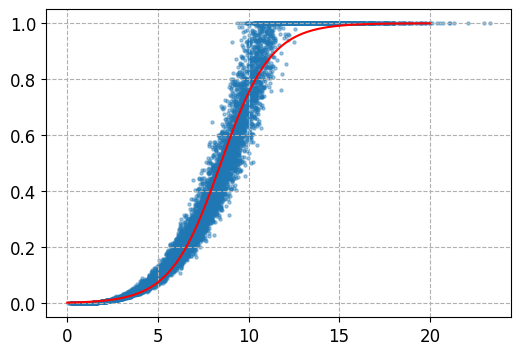

In [22]:
test_x = torch.linspace(0, 20, 401)

mean_model.eval()
with torch.no_grad():
    mean_pred = mean_model(test_x)


_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.scatter(train_x, train_y, s=5, alpha=.4)
ax.plot(test_x, mean_pred, lw=1.5, c='r')

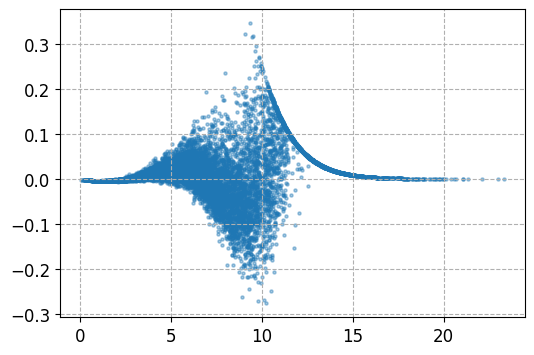

In [23]:
with torch.no_grad():
    train_y0 = train_y - mean_model(train_x)

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.scatter(train_x, train_y0, s=5, alpha=.4)

### Train model on zero mean data

In [24]:
from gpytorch.kernels import MaternKernel, RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ZeroMean
# from gpytorch.mlls import PredictiveLogLikelihood

import torch
from torch import nn


# PACKAGE IMPORTS
from gp_sand.models import BaseSparseGP


# Define model
model = BaseSparseGP(
    train_x,
    train_y0,
    mean_module=ZeroMean(),
    # covar_module=ScaleKernel(RBFKernel()),
    covar_module=ScaleKernel(MaternKernel(nu=2.5)),
    likelihood=GaussianLikelihood()
)


model.fit(
    train_x,
    train_y0,
    obj='predictive',
)

03:44:23 INFO: Iter 1 of 250: Noise:  0.644 - Loss:  1.083
03:44:25 INFO: Iter 25 of 250: Noise:  0.071 - Loss: -0.234
03:44:27 INFO: Iter 50 of 250: Noise:  0.005 - Loss: -1.395
03:44:30 INFO: Iter 75 of 250: Noise:  0.001 - Loss: -1.953
03:44:32 INFO: Iter 100 of 250: Noise:  0.000 - Loss: -2.140
03:44:34 INFO: Iter 125 of 250: Noise:  0.000 - Loss: -2.202
03:44:36 INFO: Iter 150 of 250: Noise:  0.000 - Loss: -2.227
03:44:38 INFO: Iter 175 of 250: Noise:  0.000 - Loss: -2.238
03:44:40 INFO: Iter 200 of 250: Noise:  0.000 - Loss: -2.246
03:44:42 INFO: Iter 225 of 250: Noise:  0.000 - Loss: -2.251
03:44:45 INFO: Iter 250 of 250: Noise:  0.000 - Loss: -2.255
03:44:45 INFO: Prediction scores:
+--------+-------+-----------+---------+-------+--------+-------+
| target |  bias | bias_perc |   cov   |  mae  | nrmse  |  rmse |
+--------+-------+-----------+---------+-------+--------+-------+
|  pred  | 0.000 |   0.614   | 522.945 | 0.027 | 86.501 | 0.049 |
+--------+-------+-----------+------

BaseSparseGP(
  (variational_strategy): VariationalStrategy(
    (_variational_distribution): CholeskyVariationalDistribution()
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
)

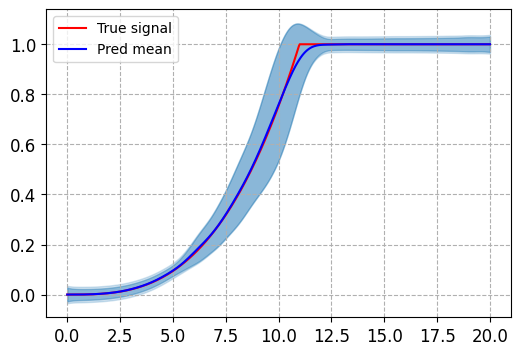

In [25]:
test_x = torch.linspace(0, 20, 501)
test_y = generator.true_signal(test_x) / generator.power_rated

# f_x, upper, lower = model.predict(test_x)

model.eval()
with torch.no_grad():
    m_x = mean_model(test_x)
    f_x = model(test_x)
    y = model.likelihood(f_x)

    lower, upper = f_x.confidence_region()
    y_lower, y_upper = y.confidence_region()

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.plot(test_x, test_y, c='r', label='True signal')
ax.plot(test_x, m_x + f_x.mean, c='blue', label='Pred mean')
ax.fill_between(
    test_x,
    m_x + lower,
    m_x + upper,
    color='tab:blue',
    alpha=.4,
)
ax.fill_between(
    test_x,
    m_x + y_lower,
    m_x + y_upper,
    color='tab:blue',
    alpha=.2,
)

ax.legend()

## Test GPyTorch implementation of Sparse GP with Heteoskedastic Noise with customized mean function

### Using Hyperbolic tangent

In [26]:
from gpytorch.kernels import MaternKernel, RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ZeroMean
# from gpytorch.mlls import PredictiveLogLikelihood

import torch
from torch import nn


# PACKAGE IMPORTS
from gp_sand.means import HyperbolicTangentMean
from gp_sand.models import BaseSparseGP


# Get training data
train_x, train_y = generator.training_data(n_samples=10000)
train_y /= generator.power_rated


# Define model
model = BaseSparseGP(
    train_x,
    train_y,
    mean_module=HyperbolicTangentMean(
        scale=nn.Parameter(
            torch.tensor(1.0),
            requires_grad=False,
        )
    ),
    # covar_module=ScaleKernel(RBFKernel()),
    covar_module=ScaleKernel(MaternKernel(nu=2.5)),
    likelihood=GaussianLikelihood()
)


model.fit(
    train_x,
    train_y,
    obj='predictive',
);

03:44:45 INFO: Iter 1 of 250: Noise:  0.644 - Loss:  1.083
03:44:48 INFO: Iter 25 of 250: Noise:  0.070 - Loss: -0.243
03:44:50 INFO: Iter 50 of 250: Noise:  0.005 - Loss: -1.392
03:44:52 INFO: Iter 75 of 250: Noise:  0.001 - Loss: -1.950
03:44:54 INFO: Iter 100 of 250: Noise:  0.000 - Loss: -2.145
03:44:56 INFO: Iter 125 of 250: Noise:  0.000 - Loss: -2.209
03:44:58 INFO: Iter 150 of 250: Noise:  0.000 - Loss: -2.235
03:45:01 INFO: Iter 175 of 250: Noise:  0.000 - Loss: -2.248
03:45:03 INFO: Iter 200 of 250: Noise:  0.000 - Loss: -2.239
03:45:05 INFO: Iter 225 of 250: Noise:  0.000 - Loss: -2.258
03:45:07 INFO: Iter 250 of 250: Noise:  0.000 - Loss: -2.263
03:45:07 INFO: Prediction scores:
+--------+-------+-----------+--------+-------+--------+-------+
| target |  bias | bias_perc |  cov   |  mae  | nrmse  |  rmse |
+--------+-------+-----------+--------+-------+--------+-------+
|  pred  | 0.000 |   0.075   | 13.265 | 0.027 | 13.781 | 0.048 |
+--------+-------+-----------+--------+-

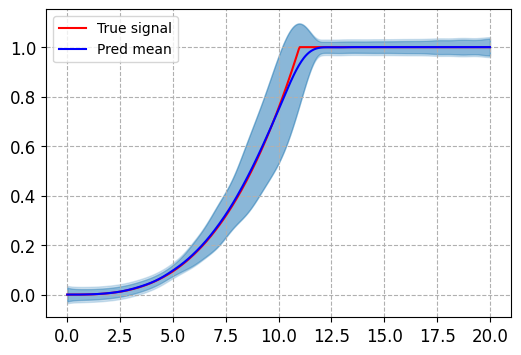

In [27]:
test_x = torch.linspace(0, 20, 501)
test_y = generator.true_signal(test_x) / generator.power_rated

# f_x, upper, lower = model.predict(test_x)

model.eval()
with torch.no_grad():
    # m_x = mean_model(test_x)
    f_x = model(test_x)
    y = model.likelihood(f_x)

    lower, upper = f_x.confidence_region()
    y_lower, y_upper = y.confidence_region()

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.plot(test_x, test_y, c='r', label='True signal')
ax.plot(test_x, f_x.mean, c='blue', label='Pred mean')
ax.fill_between(
    test_x,
    lower,
    upper,
    color='tab:blue',
    alpha=.4,
)
ax.fill_between(
    test_x,
    y_lower,
    y_upper,
    color='tab:blue',
    alpha=.2,
)

ax.legend()

### Using logistic function

In [28]:
from gpytorch.kernels import MaternKernel, RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ZeroMean
# from gpytorch.mlls import PredictiveLogLikelihood

import torch
from torch import nn


# PACKAGE IMPORTS
from gp_sand.means import LogisticMean
from gp_sand.models import BaseSparseGP


# Get training data
train_x, train_y = generator.training_data(n_samples=10000)
train_y /= generator.power_rated


# Define model
model = BaseSparseGP(
    train_x,
    train_y,
    mean_module=LogisticMean(
        scale=nn.Parameter(
            torch.tensor(1.0),
            requires_grad=False,
        )
    ),
    # covar_module=ScaleKernel(RBFKernel()),
    covar_module=ScaleKernel(MaternKernel(nu=2.5)),
    likelihood=GaussianLikelihood()
)


model.fit(
    train_x,
    train_y,
    obj='predictive',
);

03:45:08 INFO: Iter 1 of 250: Noise:  0.644 - Loss:  1.258
03:45:10 INFO: Iter 25 of 250: Noise:  0.069 - Loss: -0.239
03:45:12 INFO: Iter 50 of 250: Noise:  0.005 - Loss: -1.352
03:45:15 INFO: Iter 75 of 250: Noise:  0.001 - Loss: -1.818
03:45:17 INFO: Iter 100 of 250: Noise:  0.000 - Loss: -1.863
03:45:19 INFO: Iter 125 of 250: Noise:  0.000 - Loss: -1.921
03:45:21 INFO: Iter 150 of 250: Noise:  0.000 - Loss: -2.060
03:45:23 INFO: Iter 175 of 250: Noise:  0.000 - Loss: -2.138
03:45:26 INFO: Iter 200 of 250: Noise:  0.000 - Loss: -2.197
03:45:28 INFO: Iter 225 of 250: Noise:  0.000 - Loss: -2.205
03:45:30 INFO: Iter 250 of 250: Noise:  0.000 - Loss: -2.200
03:45:30 INFO: Prediction scores:
+--------+--------+-----------+--------+-------+--------+-------+
| target |  bias  | bias_perc |  cov   |  mae  | nrmse  |  rmse |
+--------+--------+-----------+--------+-------+--------+-------+
|  pred  | -0.000 |   -0.025  | 13.102 | 0.027 | 13.678 | 0.048 |
+--------+--------+-----------+-----

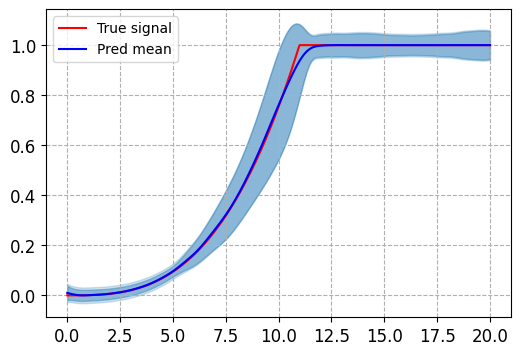

In [29]:
test_x = torch.linspace(0, 20, 501)
test_y = generator.true_signal(test_x) / generator.power_rated

# f_x, upper, lower = model.predict(test_x)

model.eval()
with torch.no_grad():
    # m_x = mean_model(test_x)
    f_x = model(test_x)
    y = model.likelihood(f_x)

    lower, upper = f_x.confidence_region()
    y_lower, y_upper = y.confidence_region()

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.plot(test_x, test_y, c='r', label='True signal')
ax.plot(test_x, f_x.mean, c='blue', label='Pred mean')
ax.fill_between(
    test_x,
    lower,
    upper,
    color='tab:blue',
    alpha=.4,
)
ax.fill_between(
    test_x,
    y_lower,
    y_upper,
    color='tab:blue',
    alpha=.2,
)

ax.legend()

### Compare mean models

In [ ]:
import torch
from torch.nn import MSELoss
from torch.optim import Adam

from gp_sand.means import HyperbolicTangentMean, LogisticMean


# Get training data
train_x, train_y = generator.training_data(n_samples=10000)
train_y /= generator.power_rated


# Define models
tanh_model = HyperbolicTangentMean(
    scale=nn.Parameter(
        torch.tensor(1.0),
        requires_grad=False,
    )
)
log_model = LogisticMean(
    scale=nn.Parameter(
        torch.tensor(1.0),
        requires_grad=False,
    )
)

# Loss and optim
tan_obj = MSELoss()
tan_optim = Adam(tanh_model.parameters(), lr=.1)
log_obj = MSELoss()
log_optim = Adam(log_model.parameters(), lr=.1)


n_epochs = 250
tanh_model.train()
log_model.train()
for n in range(n_epochs):

    # Zero grad
    tan_optim.zero_grad()
    log_optim.zero_grad()

    # Compute
    tan_pred = tanh_model(train_x)
    log_pred = log_model(train_x)

    # Losses
    tan_loss = tan_obj(tan_pred, train_y)
    tan_loss.backward()
    log_loss = log_obj(log_pred, train_y)
    log_loss.backward()

    # Step
    tan_optim.step()

    if n == 0 or (n + 1) % 25 == 0:
        msg = f'Training epoch {n + 1:2d} of {n_epochs}: ' \
              f'Loss (tanh)= {tan_loss.item()} - ' \
              f'Loss (log)= {log_loss.item()}'
              
        logger.info(msg)


for n in range(n_epochs):

    # Zero grad

    # Compute

    # Losses

    # Step
    log_optim.step()

    if n == 0 or (n + 1) % 25 == 0:
        msg = f'Training epoch {n + 1:2d} of {n_epochs}: ' \
              
        logger.info(msg)

03:45:31 INFO: Training epoch  1 of 250: Loss (tanh)= 0.004719237331300974 - 
03:45:31 INFO: Training epoch 25 of 250: Loss (tanh)= 0.0032516715582460165 - 
03:45:31 INFO: Training epoch 50 of 250: Loss (tanh)= 0.003190825693309307 - 
03:45:31 INFO: Training epoch 75 of 250: Loss (tanh)= 0.0031842447351664305 - 
03:45:31 INFO: Training epoch 100 of 250: Loss (tanh)= 0.0031841974705457687 - 
03:45:31 INFO: Training epoch 125 of 250: Loss (tanh)= 0.003184185130521655 - 
03:45:31 INFO: Training epoch 150 of 250: Loss (tanh)= 0.0031841835007071495 - 
03:45:31 INFO: Training epoch 175 of 250: Loss (tanh)= 0.003184183267876506 - 
03:45:31 INFO: Training epoch 200 of 250: Loss (tanh)= 0.003184183267876506 - 
03:45:31 INFO: Training epoch 225 of 250: Loss (tanh)= 0.003184183267876506 - 
03:45:31 INFO: Training epoch 250 of 250: Loss (tanh)= 0.003184183035045862 - 
03:45:31 INFO: Training epoch  1 of 250: Loss (log)= 0.22427479922771454
03:45:31 INFO: Training epoch 25 of 250: Loss (log)= 0.119

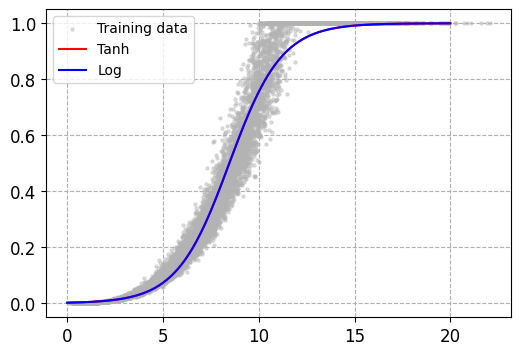

In [33]:
test_x = torch.linspace(0, 20, 401)

tanh_model.eval()
log_model.eval()
with torch.no_grad():
    tan_pred = tanh_model(test_x)
    log_pred = log_model(test_x)


_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.scatter(train_x, train_y, s=5, alpha=.4, c='.7', label='Training data')
ax.plot(test_x, tan_pred, lw=1.5, c='r', label='Tanh')
ax.plot(test_x, log_pred, lw=1.5, c='b', label='Log')

ax.legend()